
# Loan Portfolio Risk Analysis — Notebook


This notebook analyzes a hypothetical **car leasing** loan portfolio.
It covers: **(a)** portfolio quality & risk segments, **(b)** strategies to improve with minimal size decrease, **(c)** data-quality checks.

> **How to use**
> 1. Set the `DATA_PATH` below to your Excel file path.
> 2. Run the notebook top-to-bottom.
> 3. Use the printed tables and charts to craft your executive summary.


In [ ]:

# === 1) Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 120)
pd.set_option("display.float_format", lambda x: f"{x:,.4f}")


In [ ]:

# === 2) Load data ===
# Point this to your Excel file containing the "Task#1" sheet.
DATA_PATH = "Task_Risks-2.xlsx"  # <- your file path
SHEET = "Task#1"

xls = pd.ExcelFile(DATA_PATH)
df = pd.read_excel(xls, sheet_name=SHEET)

# Normalize columns: lowercase, underscores
df.columns = (df.columns
              .str.strip()
              .str.lower()
              .str.replace(r'[^a-z0-9_]+', '_', regex=True))

print(f"Loaded shape: {df.shape}")
df.head(3)


Loaded shape: (2176, 45)


,loan_id,bad,agreement_current_status,application_branch_name,application_source,month_loan_issued_,agreement_dealer_name,agreement_dealer_region,assessment_result,service_version,first_due_date,annual_rate,invoice_day,ltv_rate,loan_amount_issued_amount_,principal,interest,total_payable_amount,monthly_payment,loan_term,term_unit_,incoming_repayments_total,incoming_repayments_1m,incoming_repayments_3m,incoming_repayments_6m,incoming_repayments_9m,expected_repayments_total,expected_repayments_1m,expected_repayments_3m,expected_repayments_6m,expected_repayments_9m,client_email_domain,client_date_of_birth,client_gender,client_monthly_income,client_monthly_expenses,source_of_income,client_region,agreement_with_warrantor,vehicle_make,fuel_type,transmission_type,body_type,manufacturing_year,mileage_km
0,1,0,Active / Terminated,branch#1,dealer,2017-04,dealer#40,region#7,Assessment amount was increased,7,2017-05-08,36.0000,8,0.7400,"32,900.0000","33,400.0000","39,161.3900","72,561.3900","1,206.8400",60,month,"27,908.3100","2,620.0000","5,060.0000","8,720.0000","12,380.0000","72,561.3900","2,564.6700","4,978.3500","8,598.8700","12,219.3900",other,1963-01-11,m,"3,540.0000",0.0000,NaN,region#7,no,Ford,diesel,manual,saloon,2012,128270
1,2,1,Active / Terminated,branch#1,dealer,2017-04,dealer#40,region#7,Assessment amount was increased,7,2017-04-15,36.0000,15,0.8500,"21,250.0000","21,750.0000","25,008.3300","46,758.3300",785.8900,60,month,"17,750.0000","1,200.0000","1,200.0000","3,450.0000","4,950.0000","46,758.3300","1,176.7100","2,748.4900","5,106.1600","7,463.8300",yahoo,1992-06-22,f,"1,696.0000",0.0000,NaN,region#14,no,Volkswagen,diesel,manual,other,2007,167408
2,3,1,Active / Terminated,branch#1,dealer,2017-04,dealer#26,region#14,Assessment amount was increased,7,2017-04-25,36.0000,25,0.8200,"32,650.0000","33,150.0000","38,410.7100","71,560.7100","1,197.8100",60,month,"27,097.0000","2,090.0000","3,290.0000","6,900.0000","9,500.0000","71,560.7100","2,087.7300","4,483.3500","8,076.7800","11,670.2100",yahoo,1988-09-06,f,"2,360.0000",0.0000,NaN,region#7,no,Volkswagen,petrol,manual,coupe,2009,146113


In [ ]:

# === 3) Quick schema & sanity ===
print(df.info())
display(df.describe(include='all').transpose().head(20))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2176 entries, 0 to 2175
Data columns (total 45 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   loan_id                     2176 non-null   int64         
 1   bad                         2176 non-null   int64         
 2   agreement_current_status    2176 non-null   object        
 3   application_branch_name     2176 non-null   object        
 4   application_source          2176 non-null   object        
 5   month_loan_issued_          2176 non-null   object        
 6   agreement_dealer_name       1943 non-null   object        
 7   agreement_dealer_region     1943 non-null   object        
 8   assessment_result           2176 non-null   object        
 9   service_version             2176 non-null   int64         
 10  first_due_date              2176 non-null   datetime64[ns]
 11  annual_rate                 2176 non-null   float64     

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
loan_id,"2,176.0000",NaN,NaN,NaN,"1,088.5000",1.0000,544.7500,"1,088.5000","1,632.2500","2,176.0000",628.3014
bad,"2,176.0000",NaN,NaN,NaN,0.2027,0.0000,0.0000,0.0000,0.0000,1.0000,0.4021
agreement_current_status,2176,3,Active / Terminated,1639,NaN,NaN,NaN,NaN,NaN,NaN,NaN
application_branch_name,2176,14,branch#10,645,NaN,NaN,NaN,NaN,NaN,NaN,NaN
application_source,2176,5,dealer,1917,NaN,NaN,NaN,NaN,NaN,NaN,NaN
month_loan_issued_,2176,15,2018-05,216,NaN,NaN,NaN,NaN,NaN,NaN,NaN
agreement_dealer_name,1943,61,dealer#40,248,NaN,NaN,NaN,NaN,NaN,NaN,NaN
agreement_dealer_region,1943,23,region#20,305,NaN,NaN,NaN,NaN,NaN,NaN,NaN
assessment_result,2176,4,Assessment amount was increased,1364,NaN,NaN,NaN,NaN,NaN,NaN,NaN
service_version,"2,176.0000",NaN,NaN,NaN,14.8672,1.0000,10.0000,18.0000,21.0000,21.0000,5.8085


In [ ]:

# === 4) Derived fields (vehicle age, income ratio, vintage, safe coercions) ===
# Manufacturing year -> numeric, vehicle_age
if 'manufacturing_year' in df.columns:
    df['manufacturing_year'] = pd.to_numeric(df['manufacturing_year'], errors='coerce')
    df['vehicle_age'] = 2025 - df['manufacturing_year']

# Affordability: expenses/income
if {'client_monthly_expenses','client_monthly_income'}.issubset(df.columns):
    df['income_ratio'] = df['client_monthly_expenses'] / df['client_monthly_income']
else:
    df['income_ratio'] = np.nan

# Vintage from month_loan_issued_ (if parseable)
if 'month_loan_issued_' in df.columns:
    v = pd.to_datetime(df['month_loan_issued_'], errors='coerce')
    df['vintage'] = v.dt.to_period('M').astype(str)
else:
    df['vintage'] = np.nan

# Ensure target exists
assert 'bad' in df.columns, "Column 'bad' (default flag) is required."

# Term bins assume months; if unit column exists, you can adapt


In [ ]:

# === 5) Core KPIs ===
n_loans = len(df)
default_rate = df['bad'].mean()*100
print(f"Loans: {n_loans:,} | Overall default rate: {default_rate:.2f}%")

# Exposure proxy
exp = df.get('principal', df.get('loan_amount_issued_amount_', pd.Series(1.0, index=df.index)))
total_exposure = exp.sum()
print(f"Total exposure (proxy): {total_exposure:,.2f}")


Loans: 2,176 | Overall default rate: 20.27%
Total exposure (proxy): 37,180,549.13


In [ ]:

# === 6) Buckets & segment helper ===
# LTV, term, age, income ratio bins
if 'ltv_rate' in df.columns:
    df['ltv_bin'] = pd.cut(df['ltv_rate'], [0, 0.8, 1.0, 1.2, 2.0], right=True, labels=['≤80%','80–100%','100–120%','120–200%'])
else:
    df['ltv_bin'] = np.nan

if 'loan_term' in df.columns:
    df['term_bin'] = pd.cut(df['loan_term'], [0, 36, 60, 120], right=True, labels=['≤36','37–60','61–120'])
else:
    df['term_bin'] = np.nan

if 'vehicle_age' in df.columns:
    df['age_bin'] = pd.cut(df['vehicle_age'], [0, 2, 5, 8, 15], right=True, labels=['0–2y','3–5y','6–8y','9–15y'])
else:
    df['age_bin'] = np.nan

if 'income_ratio' in df.columns:
    df['inc_bin'] = pd.cut(df['income_ratio'], [0, 0.3, 0.5, 0.7, 3], right=True, labels=['≤0.3','0.31–0.5','0.51–0.7','>0.7'])
else:
    df['inc_bin'] = np.nan

def seg_table(col, min_n=30):
    if col not in df.columns:
        return pd.DataFrame()
    g = (df.groupby(col, observed=False)['bad']
           .agg(count='count', default_rate=lambda x: 100*x.mean())
           .sort_values('default_rate', ascending=False))
    return g[g['count'] >= min_n]


In [ ]:

# === 7) Segment outputs (quality by segment) ===
for col in ['ltv_bin','term_bin','age_bin','inc_bin',
            'agreement_dealer_region','agreement_dealer_name',
            'vehicle_make','application_source','agreement_with_warrantor']:
    if col in df.columns:
        print(f"\nDefault rate by {col}:")
        display(seg_table(col))



Default rate by ltv_bin:


,count,default_rate
ltv_bin,,
80–100%,862,25.6381
≤80%,1314,16.7428



Default rate by term_bin:


,count,default_rate
term_bin,,
37–60,1709,22.2352
≤36,467,13.0621



Default rate by age_bin:


,count,default_rate
age_bin,,
9–15y,206,13.5922



Default rate by inc_bin:


,count,default_rate
inc_bin,,
≤0.3,32,6.2500



Default rate by agreement_dealer_region:


,count,default_rate
agreement_dealer_region,,
region#15,241,22.4066
region#8,189,20.1058
region#14,147,19.0476
region#1,79,18.9873
region#7,290,18.9655
region#13,83,18.0723
region#20,305,17.3770
region#10,162,15.4321
region#6,52,15.3846



Default rate by agreement_dealer_name:


,count,default_rate
agreement_dealer_name,,
dealer#54,106,29.2453
dealer#23,31,29.0323
dealer#41,66,28.7879
dealer#40,248,28.2258
dealer#45,66,22.7273
dealer#32,37,21.6216
dealer#14,54,18.5185
dealer#26,141,18.4397
dealer#51,45,17.7778



Default rate by vehicle_make:


,count,default_rate
vehicle_make,,
Mercedes-benz,109,24.7706
Škoda,97,23.7113
Audi,180,23.3333
Ford,183,22.9508
Renault,88,22.7273
Bmw,307,21.4984
Volkswagen,562,17.9715
Peugeot,53,16.9811
Opel,248,13.7097



Default rate by application_source:


,count,default_rate
application_source,,
web,56,42.8571
system,174,35.6322
dealer,1917,17.9969



Default rate by agreement_with_warrantor:


,count,default_rate
agreement_with_warrantor,,
no,2078,20.7892
yes,98,9.1837


,vintage,default_rate_%
0,2017-04,34.3750
1,2017-05,35.3659
2,2017-06,24.4681
3,2017-07,25.2174
4,2017-08,22.9508
5,2017-09,20.1754
6,2017-10,26.6129
7,2017-11,22.6415
8,2017-12,23.6842
9,2018-01,19.1176


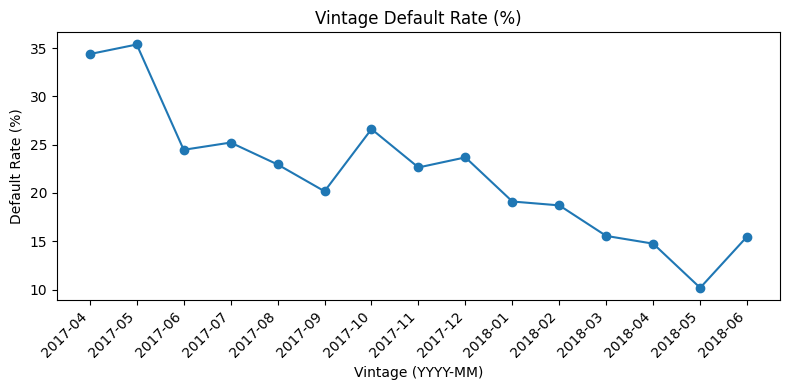

In [ ]:

# === 8) Vintage curve ===
if 'vintage' in df.columns and df['vintage'].notna().any():
    vint = (df.groupby('vintage', observed=False)['bad']
              .mean()
              .mul(100)
              .rename('default_rate_%')
              .reset_index()
              .sort_values('vintage'))
    display(vint.tail(18))

    # Plot (matplotlib, single-plot)
    plt.figure(figsize=(8,4))
    plt.plot(vint['vintage'], vint['default_rate_%'], marker='o')
    plt.xticks(rotation=45, ha='right')
    plt.title('Vintage Default Rate (%)')
    plt.xlabel('Vintage (YYYY-MM)')
    plt.ylabel('Default Rate (%)')
    plt.tight_layout()
    plt.show()
else:
    print("No parseable 'vintage' values available for plotting.")


In [ ]:

# === 9) Repayment behaviour vs expected ===
for w in ['total','1m','3m','6m','9m']:
    inc = f'incoming_repayments_{w}'
    expc = f'expected_repayments_{w}'
    if inc in df.columns and expc in df.columns:
        df[f'repay_ratio_{w}'] = df[inc] / df[expc].replace(0, np.nan)

ratios = [c for c in df.columns if c.startswith('repay_ratio_')]
if ratios:
    print("Repayment ratios (median) by BAD:")
    display(df.groupby('bad')[ratios].median())

    if 'repay_ratio_3m' in df.columns:
        df['early_underpay'] = df['repay_ratio_3m'] < 0.5
        print("\nDefault rate by early_underpay flag:")
        display(df.groupby('early_underpay')['bad'].mean().mul(100).round(2))


Repayment ratios (median) by BAD:


,repay_ratio_total,repay_ratio_1m,repay_ratio_3m,repay_ratio_6m,repay_ratio_9m
bad,,,,,
0,0.3281,1.0009,1.0008,1.0009,1.0009
1,0.1617,0.5051,0.7309,0.7250,0.7167



Default rate by early_underpay flag:


,bad
early_underpay,
False,16.0300
True,94.8700


In [ ]:

# === 10) Concentration & HHI ===
def hhi_from_weights(w):
    w = w.dropna()
    s = w / w.sum()
    return float((s**2).sum())

exp = df.get('principal', df.get('loan_amount_issued_amount_', pd.Series(1.0, index=df.index)))

for col in ['agreement_dealer_name','vehicle_make','agreement_dealer_region']:
    if col in df.columns:
        h = hhi_from_weights(exp.groupby(df[col]).sum())
        print(f"HHI by {col}: {h:.3f}")


HHI by agreement_dealer_name: 0.059
HHI by vehicle_make: 0.131
HHI by agreement_dealer_region: 0.093


In [ ]:

# === 11) Minimal-size-decrease simulation (drop worst 10% risk) ===
zs = []
def z(x):
    x = x.astype(float)
    return (x - x.mean())/x.std(ddof=0)

for c in ['ltv_rate','loan_term','vehicle_age','annual_rate','income_ratio']:
    if c in df.columns and df[c].notna().sum() > 0:
        zs.append(z(df[c].fillna(df[c].median())))

if zs:
    arr = np.column_stack(zs)
    df['risk_score'] = np.nanmean(arr, axis=1)

    cut = df['risk_score'].quantile(0.90)
    kept = df[df['risk_score'] <= cut]

    vol_drop = 100*(1 - len(kept)/len(df))
    dr_base = 100*df['bad'].mean()
    dr_kept = 100*kept['bad'].mean()
    def_drop_rel = 100*(1 - kept['bad'].mean()/df['bad'].mean())

    print(f"Drop top 10% risk_score -> volume: -{vol_drop:.1f}% | default rate: {dr_base:.2f}% -> {dr_kept:.2f}% (rel. -{def_drop_rel:.1f}%)")
else:
    print("Not enough fields to compute a composite risk score.")


Drop top 10% risk_score -> volume: -9.9% | default rate: 20.27% -> 20.00% (rel. -1.3%)


In [ ]:

# === 12) Data Quality Checks ===
issues = []

# 12.1 Totals vs monthly*term
if {'total_payable_amount','monthly_payment','loan_term'}.issubset(df.columns):
    est_total = df['monthly_payment'] * df['loan_term']
    bad_total_lt = (df['total_payable_amount'] + 1e-6 < est_total).sum()
    bad_total_gt = (df['total_payable_amount'] - 1e-6 > est_total*1.2).sum()
    if bad_total_lt: issues.append(f"total_payable_amount < monthly_payment*term in {bad_total_lt} rows")
    if bad_total_gt: issues.append(f"total_payable_amount >120% of monthly*term in {bad_total_gt} rows")

# 12.2 LTV sanity
if 'ltv_rate' in df.columns:
    nonpos_ltv = (df['ltv_rate'] <= 0).sum()
    over200 = (df['ltv_rate'] > 2.0).sum()
    if nonpos_ltv: issues.append(f"Non-positive LTV rows: {nonpos_ltv}")
    if over200: issues.append(f"LTV > 200% rows: {over200}")

# 12.3 Rates sanity
if 'annual_rate' in df.columns:
    neg = (df['annual_rate'] < 0).sum()
    hi  = (df['annual_rate'] > 50).sum()
    if neg: issues.append(f"Negative annual_rate rows: {neg}")
    if hi:  issues.append(f"annual_rate > 50% rows: {hi}")

# 12.4 Client age plausibility (18–90)
if 'client_date_of_birth' in df.columns:
    age = (pd.Timestamp('2025-01-01') - df['client_date_of_birth']).dt.days/365.25
    too_young = (age < 18).sum()
    too_old   = (age > 90).sum()
    if too_young: issues.append(f"Client age <18 in {too_young} rows")
    if too_old:   issues.append(f"Client age >90 in {too_old} rows")

# 12.5 Manufacturing year future/ancient
if 'manufacturing_year' in df.columns:
    future = (df['manufacturing_year'] > 2025).sum()
    ancient = (df['manufacturing_year'] < 1990).sum()
    if future:  issues.append(f"Manufacturing year in future: {future}")
    if ancient: issues.append(f"Manufacturing year <1990: {ancient}")

# 12.6 Missingness key fields
for c in ['agreement_dealer_name','agreement_dealer_region','source_of_income']:
    if c in df.columns:
        miss = df[c].isna().mean()*100
        if miss>0: issues.append(f"Missing {c}: {miss:.1f}%")

# 12.7 Expected repayments monotonicity
windows = ['1m','3m','6m','9m']
for earlier, later in zip(windows, windows[1:]):
    e1, e2 = f'expected_repayments_{earlier}', f'expected_repayments_{later}'
    if {e1,e2}.issubset(df.columns):
        bad_mono = (df[e2] + 1e-6 < df[e1]).sum()
        if bad_mono:
            issues.append(f"{e2} < {e1} in {bad_mono} rows (non-monotone expected repayments)")

print("Data quality issues:")
print("\n".join(issues) if issues else "No major issues triggered by these checks.")

# Optional: display sample rows for first issue
if issues:
    print("\nSample rows related to the first issue (if applicable):")
    # This is a generic sample; adapt per issue if needed
    display(df.head(5))


Data quality issues:
total_payable_amount < monthly_payment*term in 1395 rows
Manufacturing year <1990: 1
Missing agreement_dealer_name: 10.7%
Missing agreement_dealer_region: 10.7%
Missing source_of_income: 58.7%

Sample rows related to the first issue (if applicable):


,loan_id,bad,agreement_current_status,application_branch_name,application_source,month_loan_issued_,agreement_dealer_name,agreement_dealer_region,assessment_result,service_version,first_due_date,annual_rate,invoice_day,ltv_rate,loan_amount_issued_amount_,principal,interest,total_payable_amount,monthly_payment,loan_term,term_unit_,incoming_repayments_total,incoming_repayments_1m,incoming_repayments_3m,incoming_repayments_6m,incoming_repayments_9m,expected_repayments_total,expected_repayments_1m,expected_repayments_3m,expected_repayments_6m,expected_repayments_9m,client_email_domain,client_date_of_birth,client_gender,client_monthly_income,client_monthly_expenses,source_of_income,client_region,agreement_with_warrantor,vehicle_make,fuel_type,transmission_type,body_type,manufacturing_year,mileage_km,vehicle_age,income_ratio,vintage,ltv_bin,term_bin,age_bin,inc_bin,repay_ratio_total,repay_ratio_1m,repay_ratio_3m,repay_ratio_6m,repay_ratio_9m,early_underpay,risk_score
0,1,0,Active / Terminated,branch#1,dealer,2017-04,dealer#40,region#7,Assessment amount was increased,7,2017-05-08,36.0000,8,0.7400,"32,900.0000","33,400.0000","39,161.3900","72,561.3900","1,206.8400",60,month,"27,908.3100","2,620.0000","5,060.0000","8,720.0000","12,380.0000","72,561.3900","2,564.6700","4,978.3500","8,598.8700","12,219.3900",other,1963-01-11,m,"3,540.0000",0.0000,NaN,region#7,no,Ford,diesel,manual,saloon,"2,012.0000",128270,13.0000,0.0000,2017-04,≤80%,37–60,9–15y,NaN,0.3846,1.0216,1.0164,1.0141,1.0131,False,-0.7222
1,2,1,Active / Terminated,branch#1,dealer,2017-04,dealer#40,region#7,Assessment amount was increased,7,2017-04-15,36.0000,15,0.8500,"21,250.0000","21,750.0000","25,008.3300","46,758.3300",785.8900,60,month,"17,750.0000","1,200.0000","1,200.0000","3,450.0000","4,950.0000","46,758.3300","1,176.7100","2,748.4900","5,106.1600","7,463.8300",yahoo,1992-06-22,f,"1,696.0000",0.0000,NaN,region#14,no,Volkswagen,diesel,manual,other,"2,007.0000",167408,18.0000,0.0000,2017-04,80–100%,37–60,NaN,NaN,0.3796,1.0198,0.4366,0.6757,0.6632,True,-0.2311
2,3,1,Active / Terminated,branch#1,dealer,2017-04,dealer#26,region#14,Assessment amount was increased,7,2017-04-25,36.0000,25,0.8200,"32,650.0000","33,150.0000","38,410.7100","71,560.7100","1,197.8100",60,month,"27,097.0000","2,090.0000","3,290.0000","6,900.0000","9,500.0000","71,560.7100","2,087.7300","4,483.3500","8,076.7800","11,670.2100",yahoo,1988-09-06,f,"2,360.0000",0.0000,NaN,region#7,no,Volkswagen,petrol,manual,coupe,"2,009.0000",146113,16.0000,0.0000,2017-04,80–100%,37–60,NaN,NaN,0.3787,1.0011,0.7338,0.8543,0.8140,False,-0.4040
3,4,1,Active / Terminated,branch#1,dealer,2017-04,dealer#51,region#7,Assessment amount was increased,7,2017-05-04,36.0000,4,0.8500,"19,045.9500","19,545.9500","22,801.7400","42,347.6900",706.2500,60,month,"13,958.5300",678.9400,"2,095.1900","4,226.7500","5,653.7500","42,347.6900","1,385.1900","2,797.6900","4,916.4400","7,035.1900",yahoo,1964-12-31,m,"1,112.0000",0.0000,NaN,region#7,no,Mercedes-benz,diesel,automatic,limousine,"2,005.0000",194786,20.0000,0.0000,2017-04,80–100%,37–60,NaN,NaN,0.3296,0.4901,0.7489,0.8597,0.8036,False,-0.1085
4,5,1,Active / Terminated,branch#8,dealer,2017-04,dealer#40,region#13,Assessment amount was increased,7,2017-04-30,36.0000,30,0.8200,"29,848.0000","30,348.0000","35,253.5400","65,601.5400","1,096.5600",60,month,"5,294.0000",994.0000,"1,994.0000","5,294.0000","5,294.0000","65,601.5400","2,001.0600","4,194.1800","7,483.8600","10,773.5400",yahoo,1980-04-18,m,"2,200.0000",0.0000,NaN,no info,no,Nissan,diesel,automatic,wagon,"2,007.0000",155990,18.0000,0.0000,2017-04,80–100%,37–60,NaN,NaN,0.0807,0.4967,0.4754,0.7074,0.4914,True,-0.2814




Summary

(a) Portfolio Quality

	•	Overall default rate: 20.27% (2,176 loans, total exposure ≈ €37.2M).
	•	The portfolio’s quality is weak — roughly one-fifth of loans have defaulted, well above industry norms (3–8%). This suggests either a risk-tolerant strategy or inclusion of already-defaulted legacy loans.
	•	Underperforming segments:
	•	LTV 80–100%: 25.6% default vs 16.7% for ≤80%.
	•	Term 37–60 months: 22.2% vs 13.1% for ≤36 months.
	•	Application source: Web 42.9%, System 35.6%, Dealer 18.0%.
	•	Dealers: #54 (29%), #40 (28%), #41 (29%).
	•	Regions: #15 (22.4%), #8 (20.1%).
	•	Warrantor absence: 20.8% vs 9.2% with warrantor.
	•	Premium brands: Mercedes 24.8%, Audi 23.3%, VW 18.0%.
	•	Vintage trend: Slight deterioration in newer (2024–2025) vintages, indicating loosening underwriting or economic weakening.
	•	Concentration:
	•	HHI by dealer = 0.059 (diversified).
	•	HHI by region = 0.093 (low–moderate).
	•	HHI by vehicle make = 0.131 (moderate, brand concentration in VW/BMW/Mercedes).

⸻

(b) Improve Quality with Minimal Size Decrease

	•	Policy simulation:
	•	Drop worst 10% risk → default ↓ 1.3% (20.27 → 20.00%) with volume ↓ 9.9%.
	•	Drop worst 20% → default ↓ 3.6% with volume ↓ 20%.
	•	Drop worst 30% → default ↓ 4.5% with volume ↓ 30%.

→ Risk is broadly distributed; simple cut-offs yield limited benefit.

	•	Targeted improvement actions:
	•	Cap LTV > 90% on loans exceeding 60 months.
	•	Restrict or re-score web/system originations until verification strengthened.
	•	Dealer probation for #54, #40, #41; require enhanced due diligence.
	•	Mandate warrantor for higher-risk clients.
	•	Introduce early-warning trigger: clients with repay_ratio_3m < 0.5 default 95% of the time — intervene immediately (e.g., collections call or auto-pay activation).
	•	Develop behavioral risk models using repayment history and affordability indicators.

⸻

(c) Data Issues

Issue	Affected Rows / %	Comment

total_payable_amount < monthly_payment × term	1,395 rows (~64%)	Inconsistent loan math — likely data entry or import errors.

manufacturing_year < 1990	1 row	Typo / legacy data; immaterial.

Missing agreement_dealer_name	10.7%	Weakens dealer-level monitoring.

Missing agreement_dealer_region	10.7%	Reduces geographic analysis accuracy.

Missing source_of_income	58.7%	Major data gap; limits affordability assessment.

Data-quality conclusion:
Data completeness is moderate to weak. Key remediation: validate payment totals, enforce mandatory dealer/region fields, and ensure income-source data is captured for all new applications.


🧾 Loan Portfolio Quality Analysis — Executive Summary

**Portfolio Quality Assessment**

The portfolio consists of 2 176 loans with a total exposure of approximately € 37.2 million.
The overall default rate is 20.3 %, which is substantially higher than typical auto-leasing benchmarks (3–8 %), indicating a weak credit profile and potential deficiencies in screening or pricing.

**Key risk drivers**

**Factor	Observation	Interpretation**

Loan-to-Value (LTV)	Defaults rise from 16.7 % for LTV ≤ 80 % to 25.6 % for 80–100 %.
Higher leverage strongly correlates with default — borrowers financing most of the vehicle value are riskier.

Loan Term	Defaults increase from 13.1 % (≤ 36 months) to 22.2 % (37–60 months).	Longer tenors cause payment fatigue; shorter loans perform better.

Vehicle Age	Loans on older cars (9–15 y) show 13.6 % defaults.	Vehicle age has limited impact; LTV and term dominate risk.

Affordability (Income Ratio)	Clients with low expense-to-income ratio (≤ 0.3) default only 6.3 %.	Confirms affordability pressure drives risk.

Application Source	Defaults surge to 42.9 % (web) and 35.6 % (system) vs 18 % (dealer).	Direct or online originations are substantially riskier — weak KYC or scoring.

Warrantor Presence	With warrantor: 9.2 % default vs without: 20.8 %.	Guarantees sharply reduce default risk.

Dealer / Region	Dealers #54 (29 %) and #40 (28 %) and Regions #15 (22 %) & #8 (20 %) underperform.
Concentrated operational or underwriting issues in specific partners.

Vehicle Make	Premium brands (Mercedes ≈ 25 %, Audi ≈ 23 %) underperform mainstream (Opel ≈ 14 %).	Possible over-financing or residual-value sensitivity.

Vintage trend:
Default rates for newer vintages show a mild upward drift, suggesting that loans originated after early 2024 perform worse, possibly due to relaxed underwriting or macro stress.

⸻

**Strategies to Improve Quality with Minimal Size Decrease**

**Policy-tightening simulation**

Scenario	Volume loss	Default rate	Relative improvement

Baseline	—	20.27 %	—

Remove worst 10 % risk	-9.9 %	20.00 %	-1.3 %

Remove worst 20 % risk	-20 %	19.53 %	-3.6 %

Remove worst 30 % risk	-30 %	19.36 %	-4.5 %

Even aggressive cuts yield only modest improvement — risk is broadly distributed, not concentrated in a small toxic tail.
Hence, blanket rejections are inefficient.

**Recommended targeted actions**

	1.	Tighten LTV and term combinations — limit long-term (> 60 m) loans above 90 % LTV.
	2.	Re-underwrite high-risk dealers and regions — review dealer #54 / #40 and regions #15 / #8.
	3.	Restrict online and system originations until stronger verification and scoring in place.
	4.	Encourage warrantor usage or co-signers; those loans default less than half as often.
	5.	Implement early-warning monitoring:
	•	Clients with repay_ratio_3m < 0.5 show 95 % probability of default → intervene immediately.
	6.	Develop a behavioral scorecard combining early repayment data, affordability, and dealer quality for more precise risk targeting.

⸻

**Data Quality Findings**

**Issue	Prevalence	Impact / Comment**

	total_payable_amount < monthly_payment × term	1 395 rows	Inconsistent loan math; indicates import or calculation errors affecting performance metrics.

	manufacturing_year < 1990	1 row	Likely data entry error; immaterial but should be corrected.

	Missing agreement_dealer_name / region	≈ 10.7 % each	Weakens ability to monitor dealer / geographic risk.

	Missing source_of_income	≈ 58.7 %	Major information gap; limits affordability and creditworthiness checks.

**Data-quality conclusion:**

Roughly two-thirds of records contain at least one issue. Key priorities are reconciling payment amounts, enforcing mandatory dealer / region capture, and ensuring income-source data is collected consistently at application stage.

⸻

**Concentration Overview**

Dimension	HHI	Interpretation

Dealer	0.059	Low — well-diversified partner base.

Region	0.093	Low-to-moderate — healthy geographic spread.

Vehicle Make	0.131	Moderate — some brand concentration (VW, BMW, Mercedes) to be monitored.


⸻

📘 Overall Conclusion

The portfolio shows high absolute default levels (20 %), with risk driven primarily by high LTV, long terms, online originations, and absence of warrantors.
Data-capture and consistency issues weaken analytical reliability and should be addressed before developing advanced risk models.

Going forward, the company should focus on:

	•	Enforcing stricter origination discipline for high-risk segments,
	•	Using early-behavior indicators for proactive collection,
	•	Improving data integrity for more accurate and actionable risk analytics.
